# EDA

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
 
import warnings
warnings.filterwarnings('ignore')

In [44]:
df = pd.read_csv('data/processed/data.csv')
df.head()


,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,...,locale,is_holiday,transactions,year,month,day_of_week,is_weekend,shift_1,roll_mean_7,roll_std_7
0,0,12474,2013-01-08,1,AUTOMOTIVE,2.0,0,93.21,Quito,Pichincha,...,Not Holiday,0,1869.0,2013,1,1,0,0.0,2.142857,1.772811
1,1,12475,2013-01-08,1,BABY CARE,0.0,0,93.21,Quito,Pichincha,...,Not Holiday,0,1869.0,2013,1,1,0,0.0,0.000000,0.000000
2,2,12476,2013-01-08,1,BEAUTY,3.0,0,93.21,Quito,Pichincha,...,Not Holiday,0,1869.0,2013,1,1,0,1.0,1.285714,1.380131
3,3,12477,2013-01-08,1,BEVERAGES,1029.0,0,93.21,Quito,Pichincha,...,Not Holiday,0,1869.0,2013,1,1,0,1158.0,812.571429,442.221233
4,4,12478,2013-01-08,1,BOOKS,0.0,0,93.21,Quito,Pichincha,...,Not Holiday,0,1869.0,2013,1,1,0,0.0,0.000000,0.000000


In [45]:
## From object to date type
df['date'] = pd.to_datetime(df['date'])

In [46]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 200

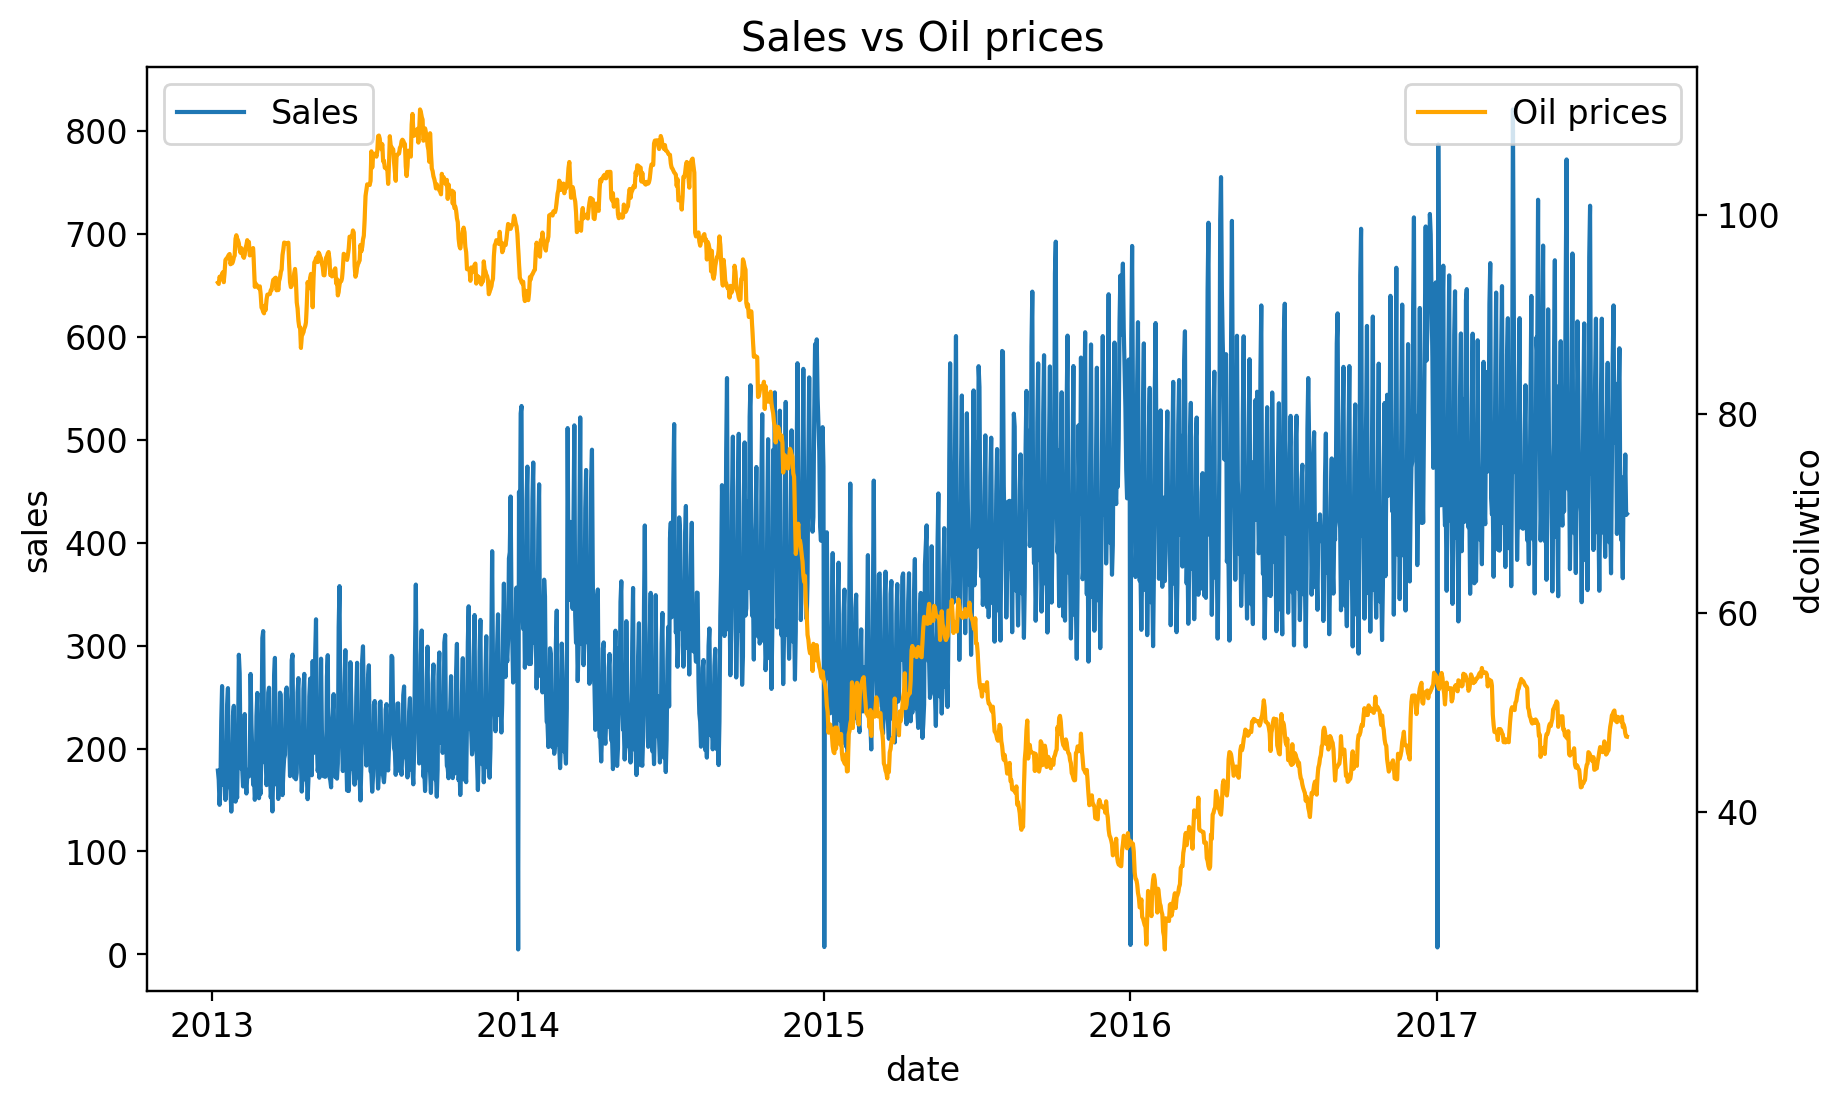

In [47]:
## Sales vs Oil prices
sns.lineplot(data=df, x='date', y='sales', label='Sales', errorbar=None)
ax2 = plt.gca().twinx()
ax = plt.gca()
sns.lineplot(data=df, x='date', y='dcoilwtico', color='orange', label='Oil prices', ax=ax2)
plt.title('Sales vs Oil prices')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


There is no strong relationship between sales and the price of oil, but in 2015, with a sharp drop in oil prices, the number of sales also decreased sharply, which may indicate a slight relationship between these values.

Text(0.5, 1.0, 'Average Sales by Month')

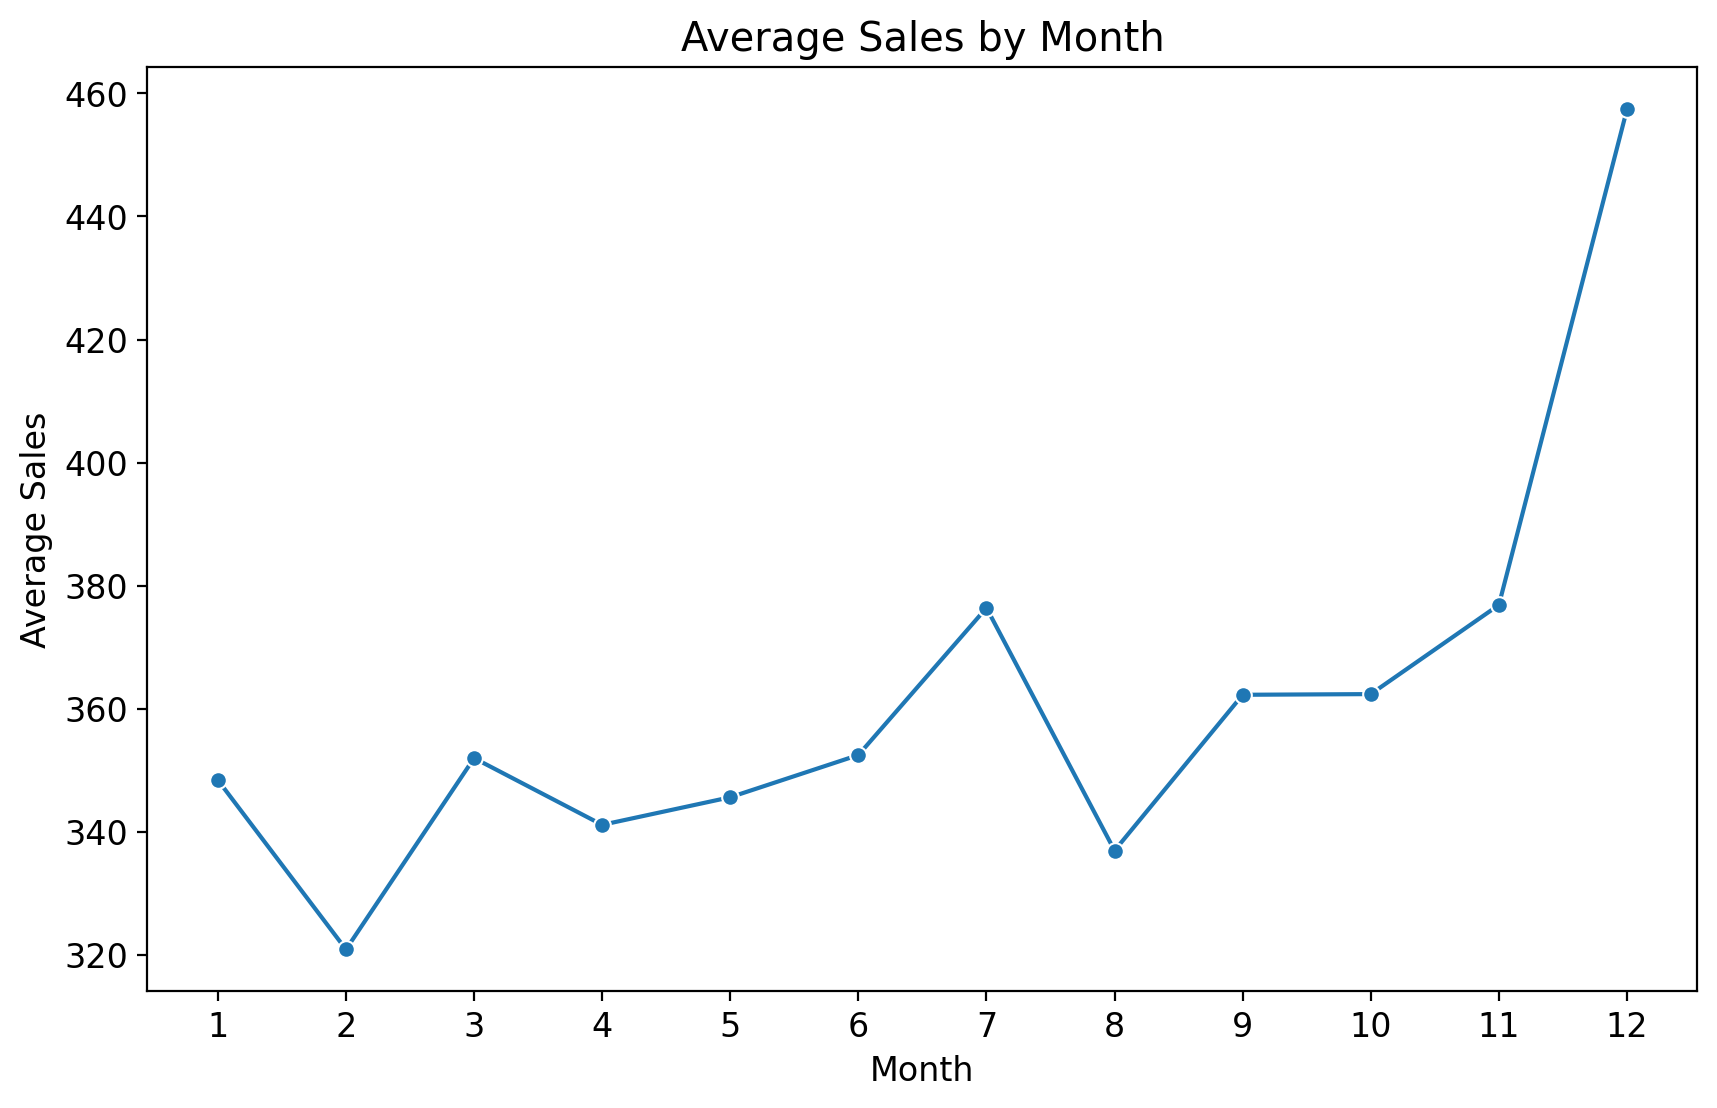

In [48]:
## Average Sales by Month
avrsales_by_month = df.groupby('month')['sales'].mean().reset_index()
sns.lineplot(data=avrsales_by_month, x='month', y='sales', marker='o')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.title('Average Sales by Month')

Based on the chart, sales rise and fall every year, with the minimum value in February and the maximum in December (due to the New Year)

Text(0.5, 1.0, 'Total sales by Store')

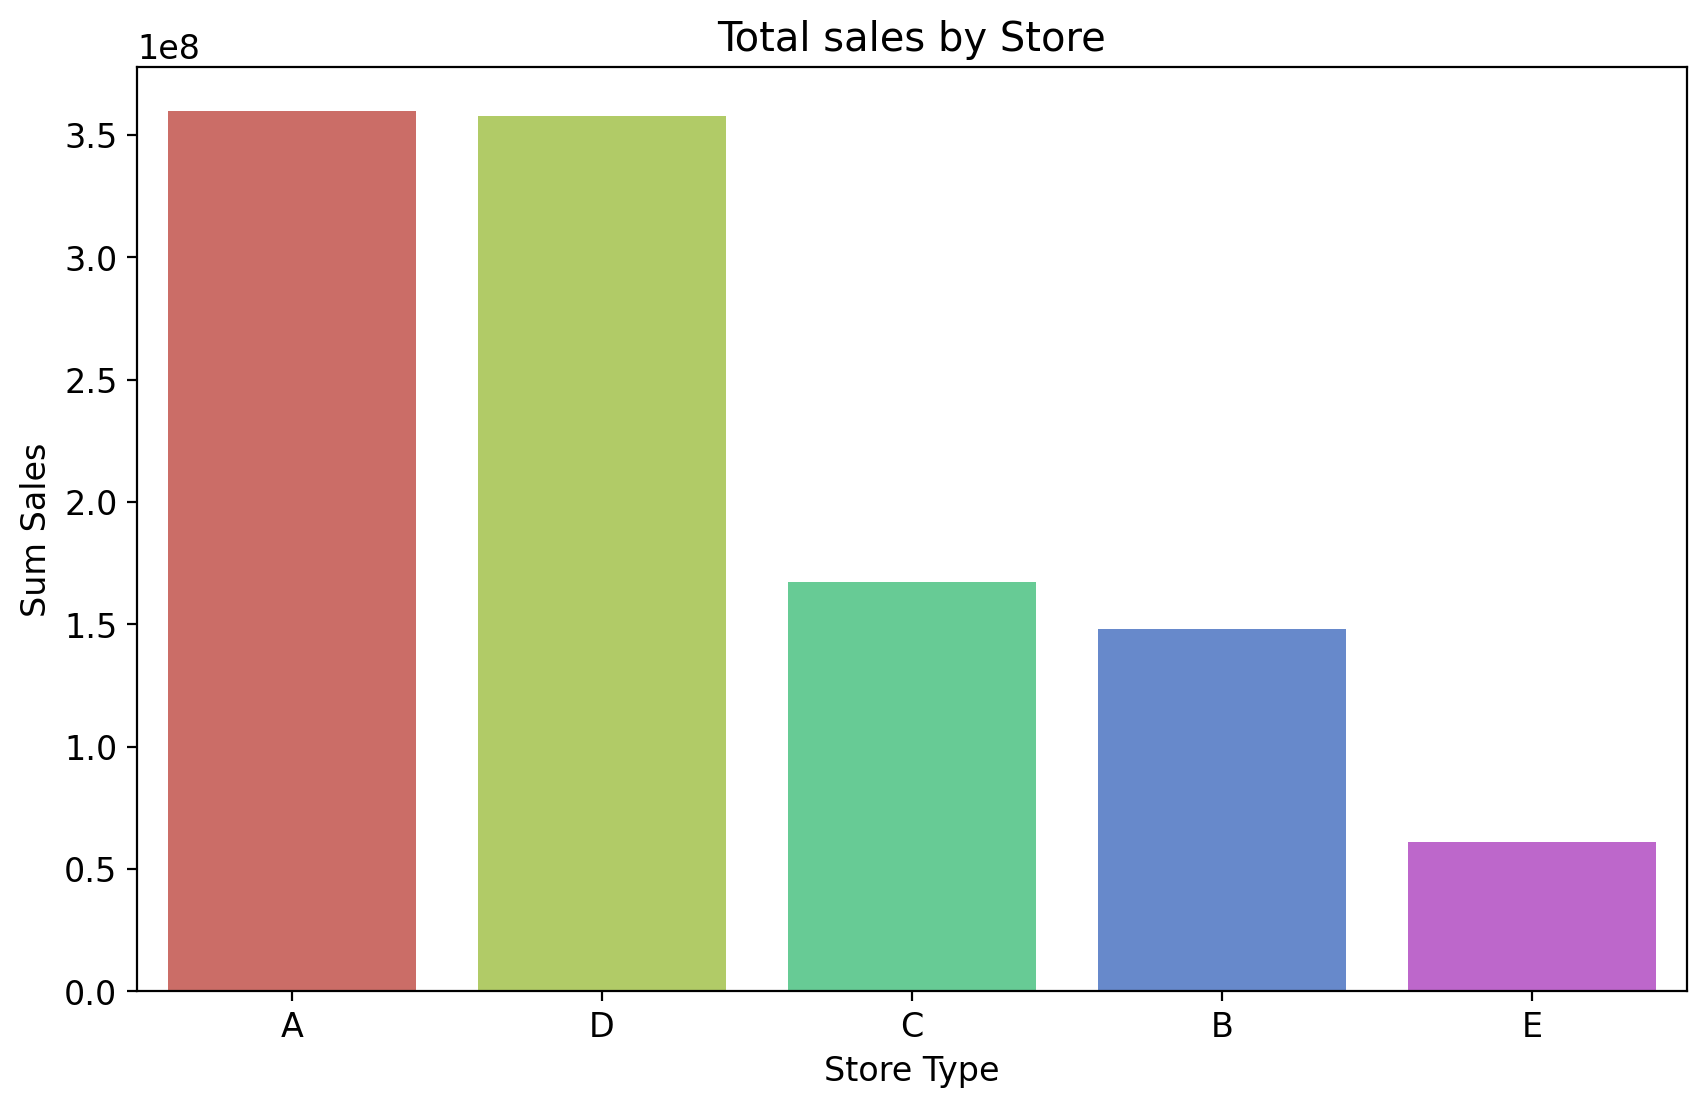

In [49]:
## Total Sales by Store
sales_by_store_type = df.groupby('store_type')['sales'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=sales_by_store_type,
             x='store_type',
             y='sales',
             palette='hls',
             hue='store_type')
plt.xlabel('Store Type')
plt.ylabel('Sum Sales')
plt.title('Total sales by Store')

You can see that stores A and D have the most sales compared to the rest.

Text(0.5, 1.0, 'Store: 3. Transactions vs Sales')

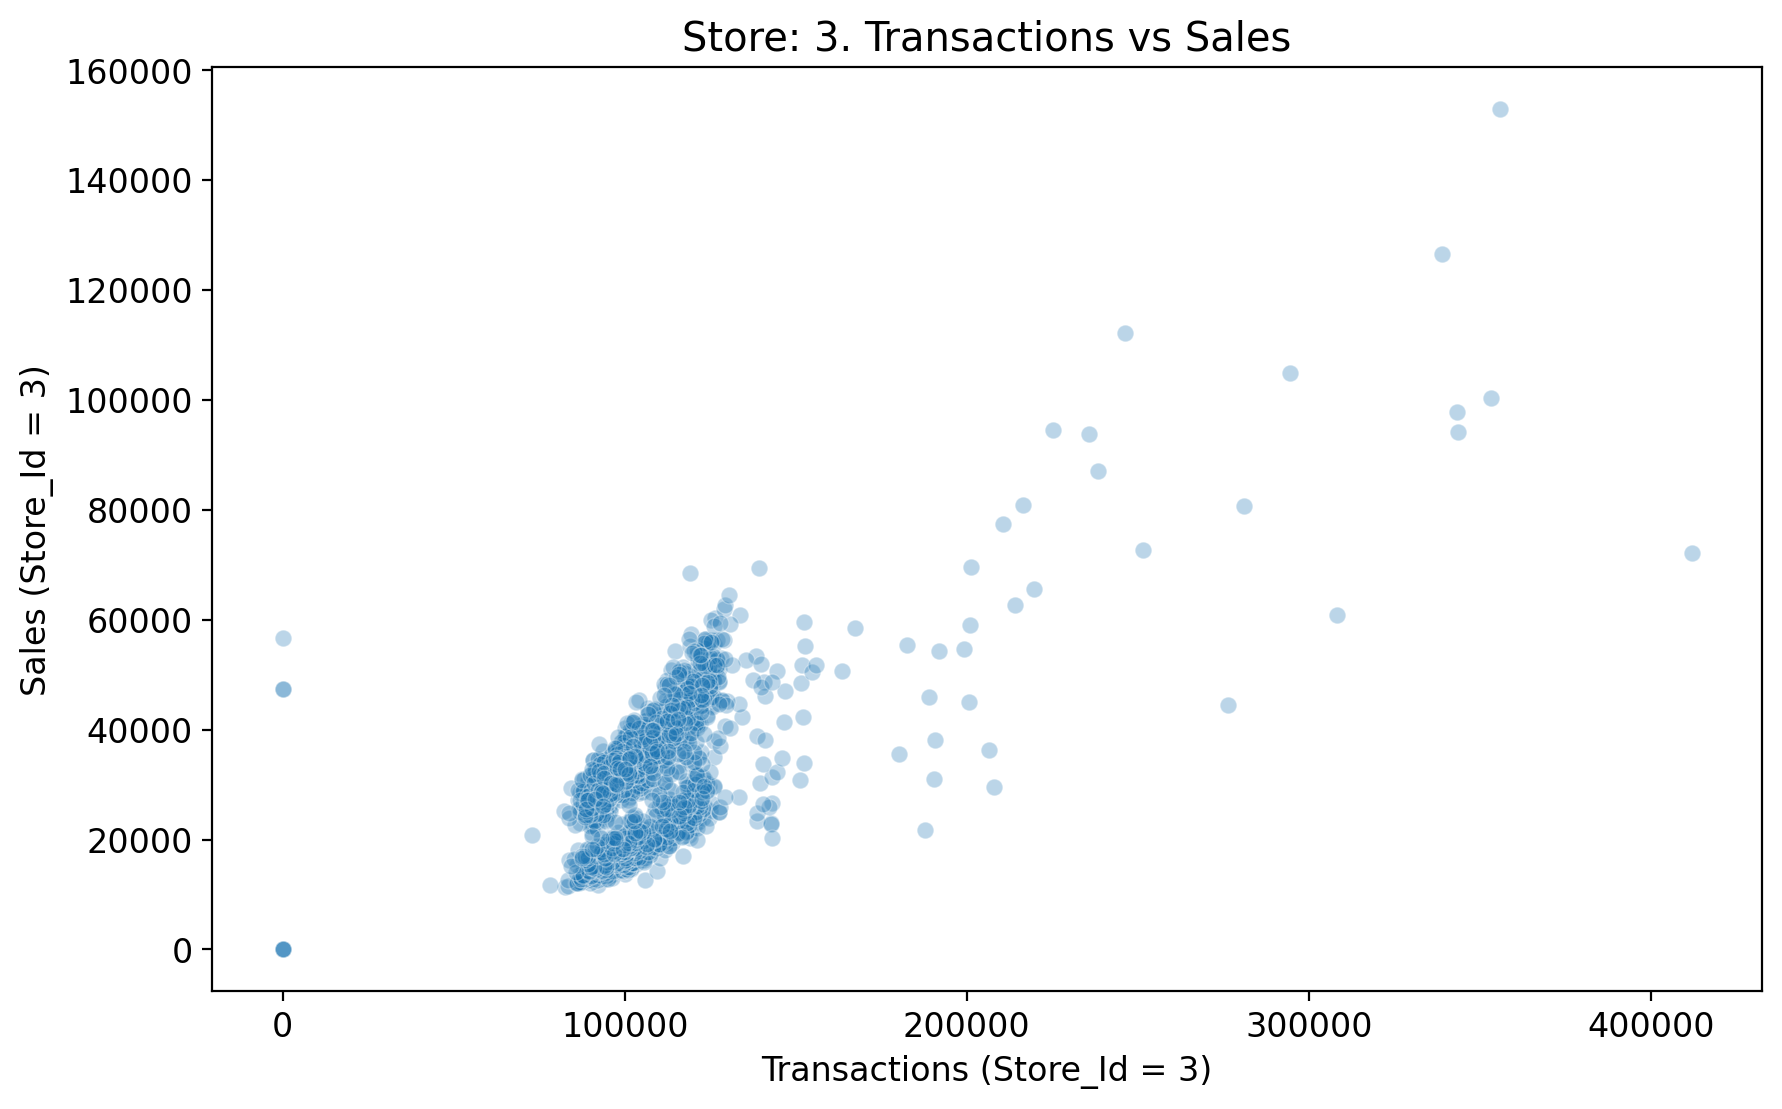

In [50]:
## Transactions vs Sales for store_type=3
store_id = 3
store_sales = df[df['store_nbr'] == store_id].groupby('date')['sales'].sum().reset_index()
store_trans = df[df['store_nbr'] == store_id].groupby('date')['transactions'].sum().reset_index()
store_merged = store_sales.merge(store_trans, on='date', how='left')

sns.scatterplot(data=store_merged, x='transactions', y='sales', alpha=0.3)
plt.xlabel(f"Transactions (Store_Id = {store_id})")
plt.ylabel(f"Sales (Store_Id = {store_id})")
plt.title(f"Store: {store_id}. Transactions vs Sales")

The graph of the dependence of daily sales on the daily number of transactions shows a strong relationship, and as sales grow, so does the number of transactions. This is __a very important feature__ for the model.

In [51]:
daily_promo = df.groupby(['date', 'onpromotion'])['sales'].sum().reset_index()
daily_promo['day_name'] = daily_promo['date'].dt.day_name()
daily_promo['onpromotion'] = daily_promo['onpromotion'].map(lambda x: 'Promo' if x != 0 else 'No Promo')
daily_promo = daily_promo.rename(columns={'onpromotion': 'promo_type'})

Text(0.5, 1.0, 'Daily Total Sales by Day of Week\nPromo vs No Promo')

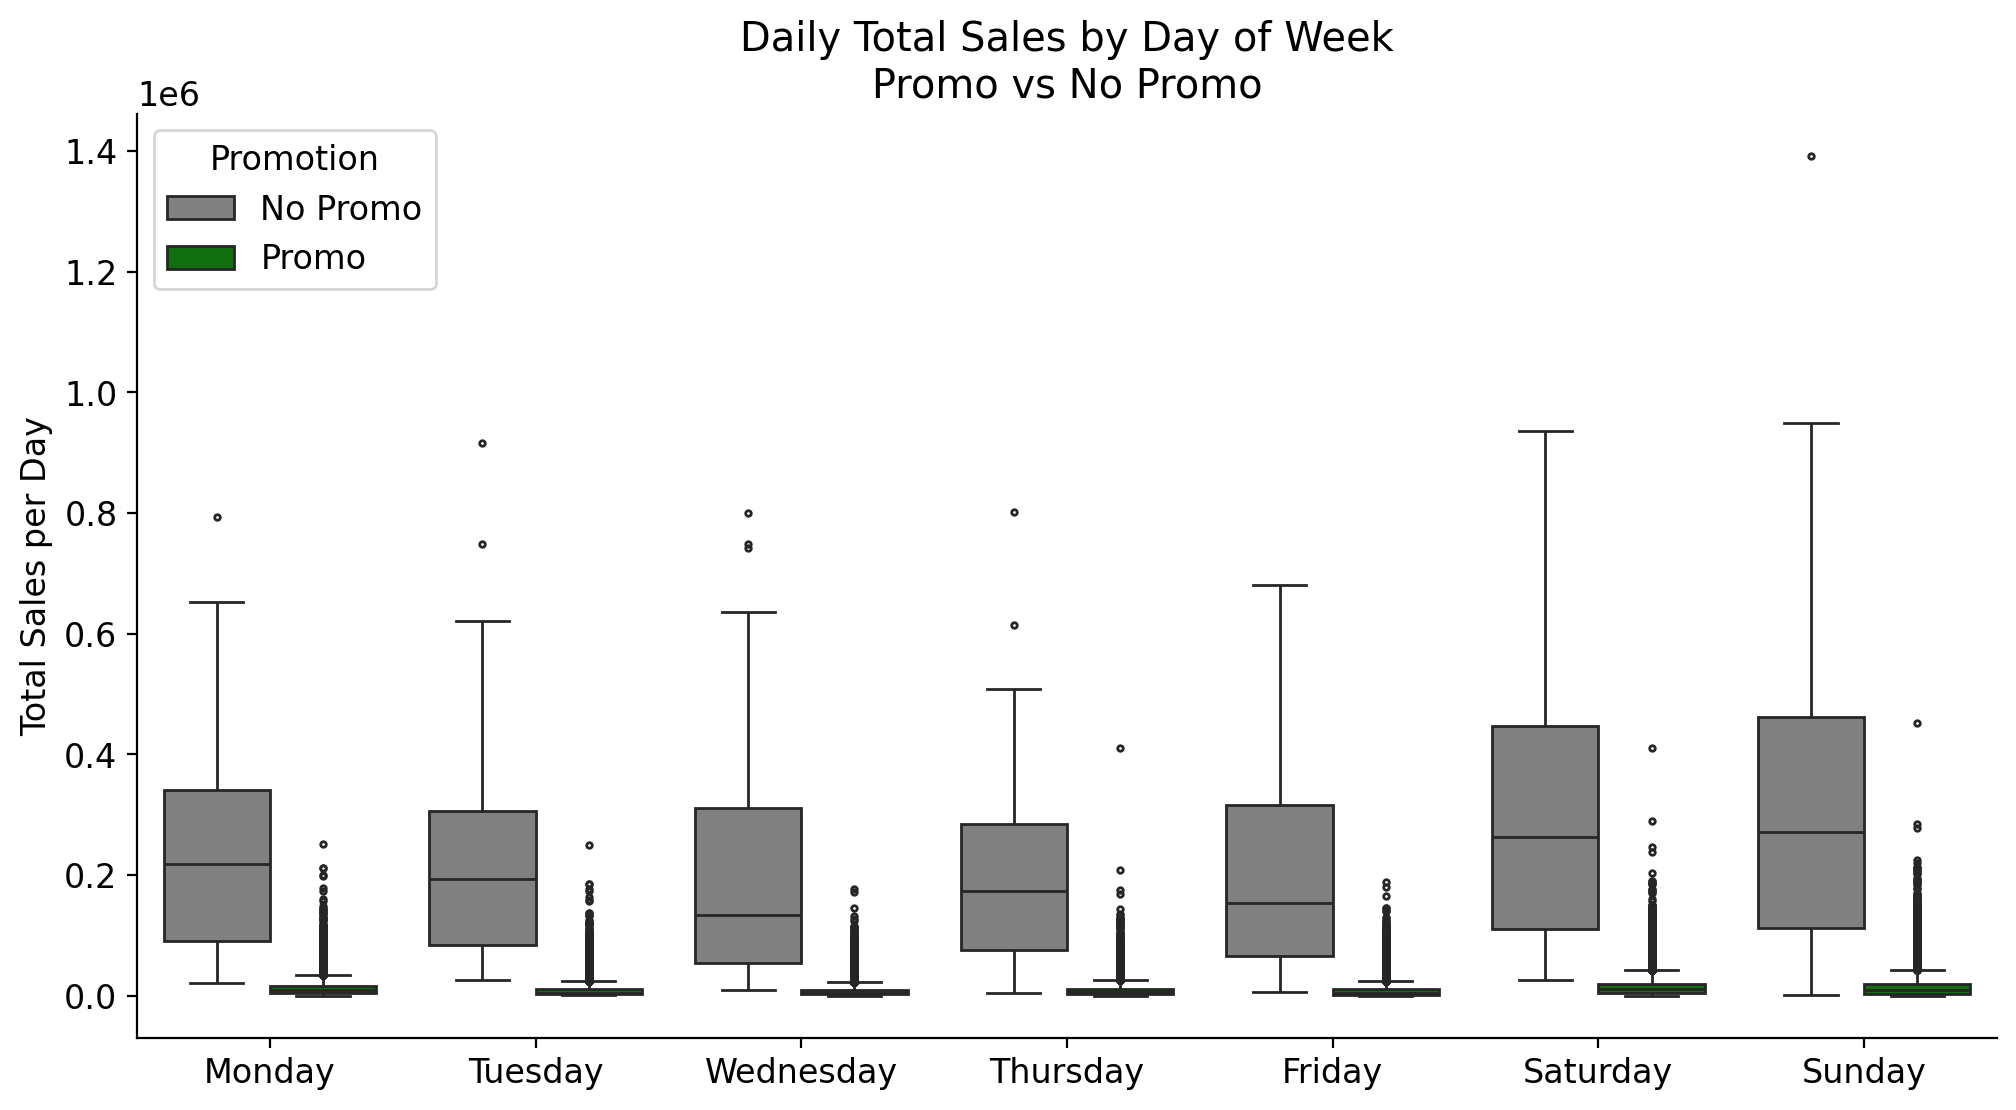

In [52]:
## Average number of sales by day of the week, including promotions
plt.figure(figsize=(12, 6))

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pallete = {'No Promo': 'gray', 'Promo': 'green'}



sns.boxplot(
    data=daily_promo,
    x='day_name',
    y='sales',
    hue='promo_type',
    order=order,
    palette=pallete,
    fliersize=2,
    linewidth=1
)
sns.despine(left=False, bottom=False)

plt.xlabel("")
plt.ylabel("Total Sales per Day")
plt.legend(title='Promotion', loc='upper left')
plt.title("Daily Total Sales by Day of Week\nPromo vs No Promo")

Based on the chart, on average, the average number of sales without a promo is much higher than with a promo. Also, the largest number of sales occur on weekends.

<Axes: xlabel='sales', ylabel='Count'>

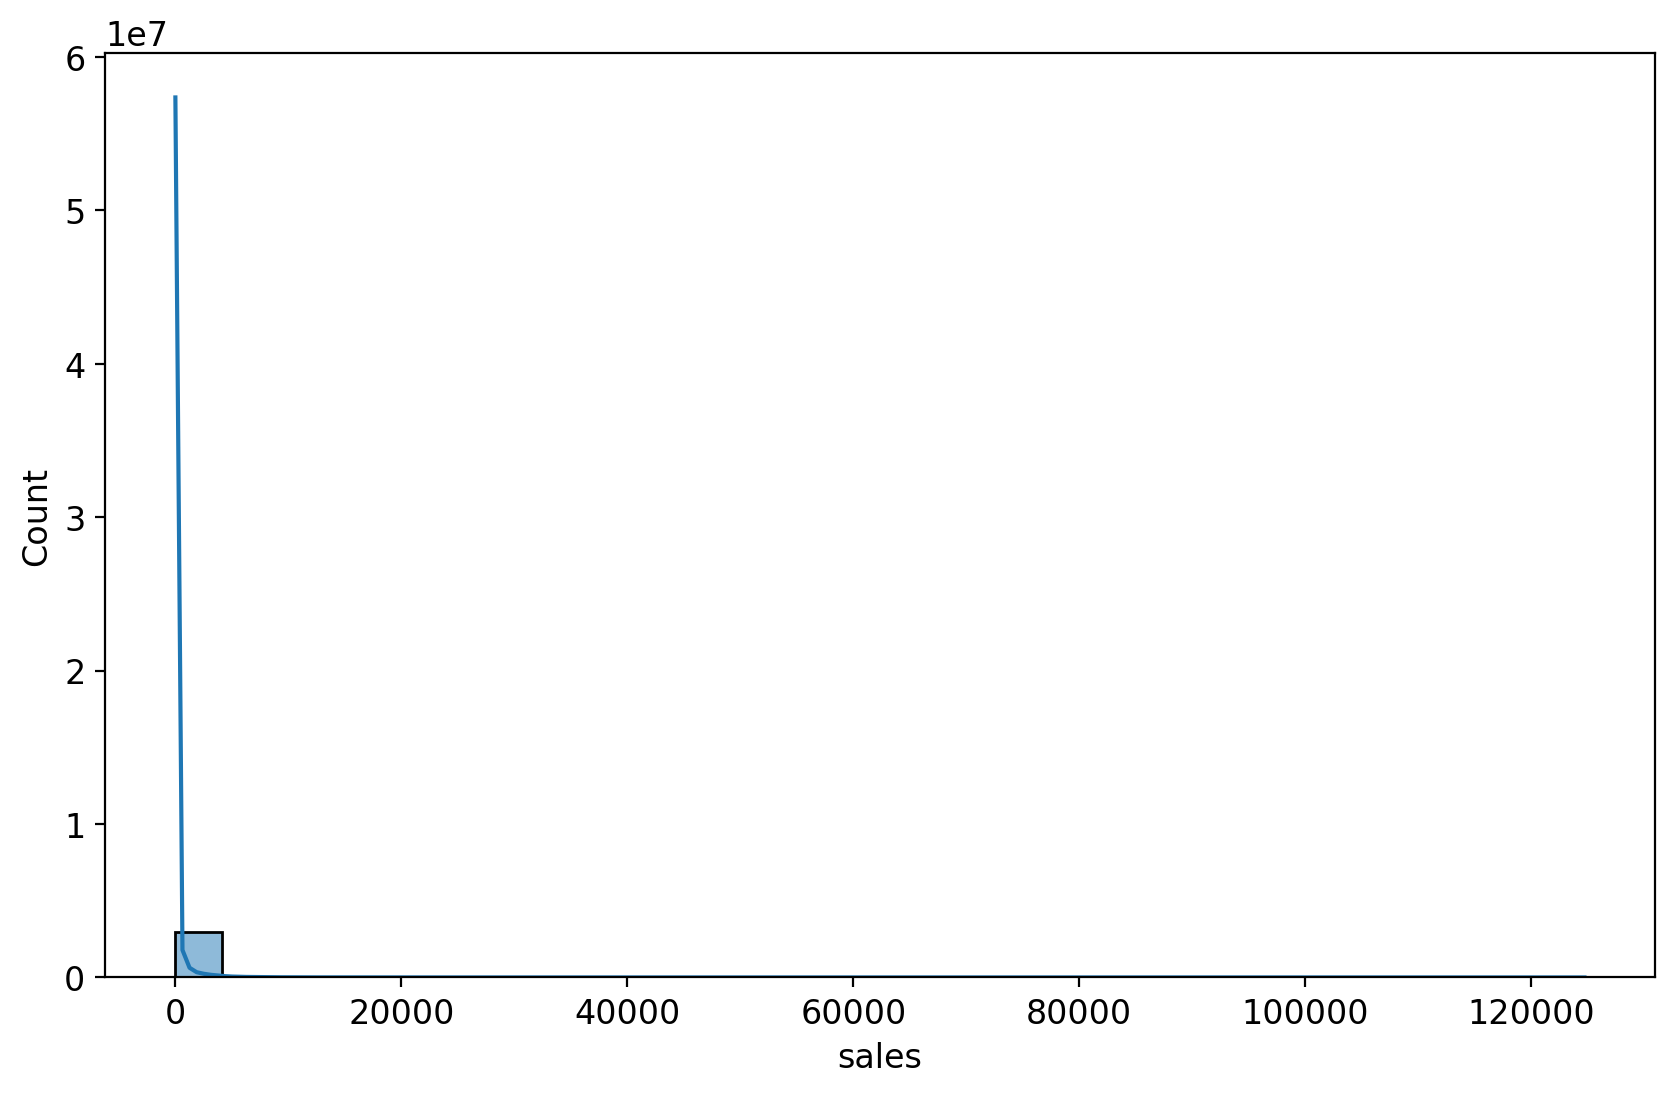

In [53]:
sns.histplot(data=df, x='sales', bins=30, kde=True)

Based on the graph, we can say that some of the goods are sold in very small quantities, while there is a large tail of goods that are bought in large quantities. This may be related to holidays, special promotions, weekends, and the like.

Text(0.5, 1.0, 'Average Sales by Family')

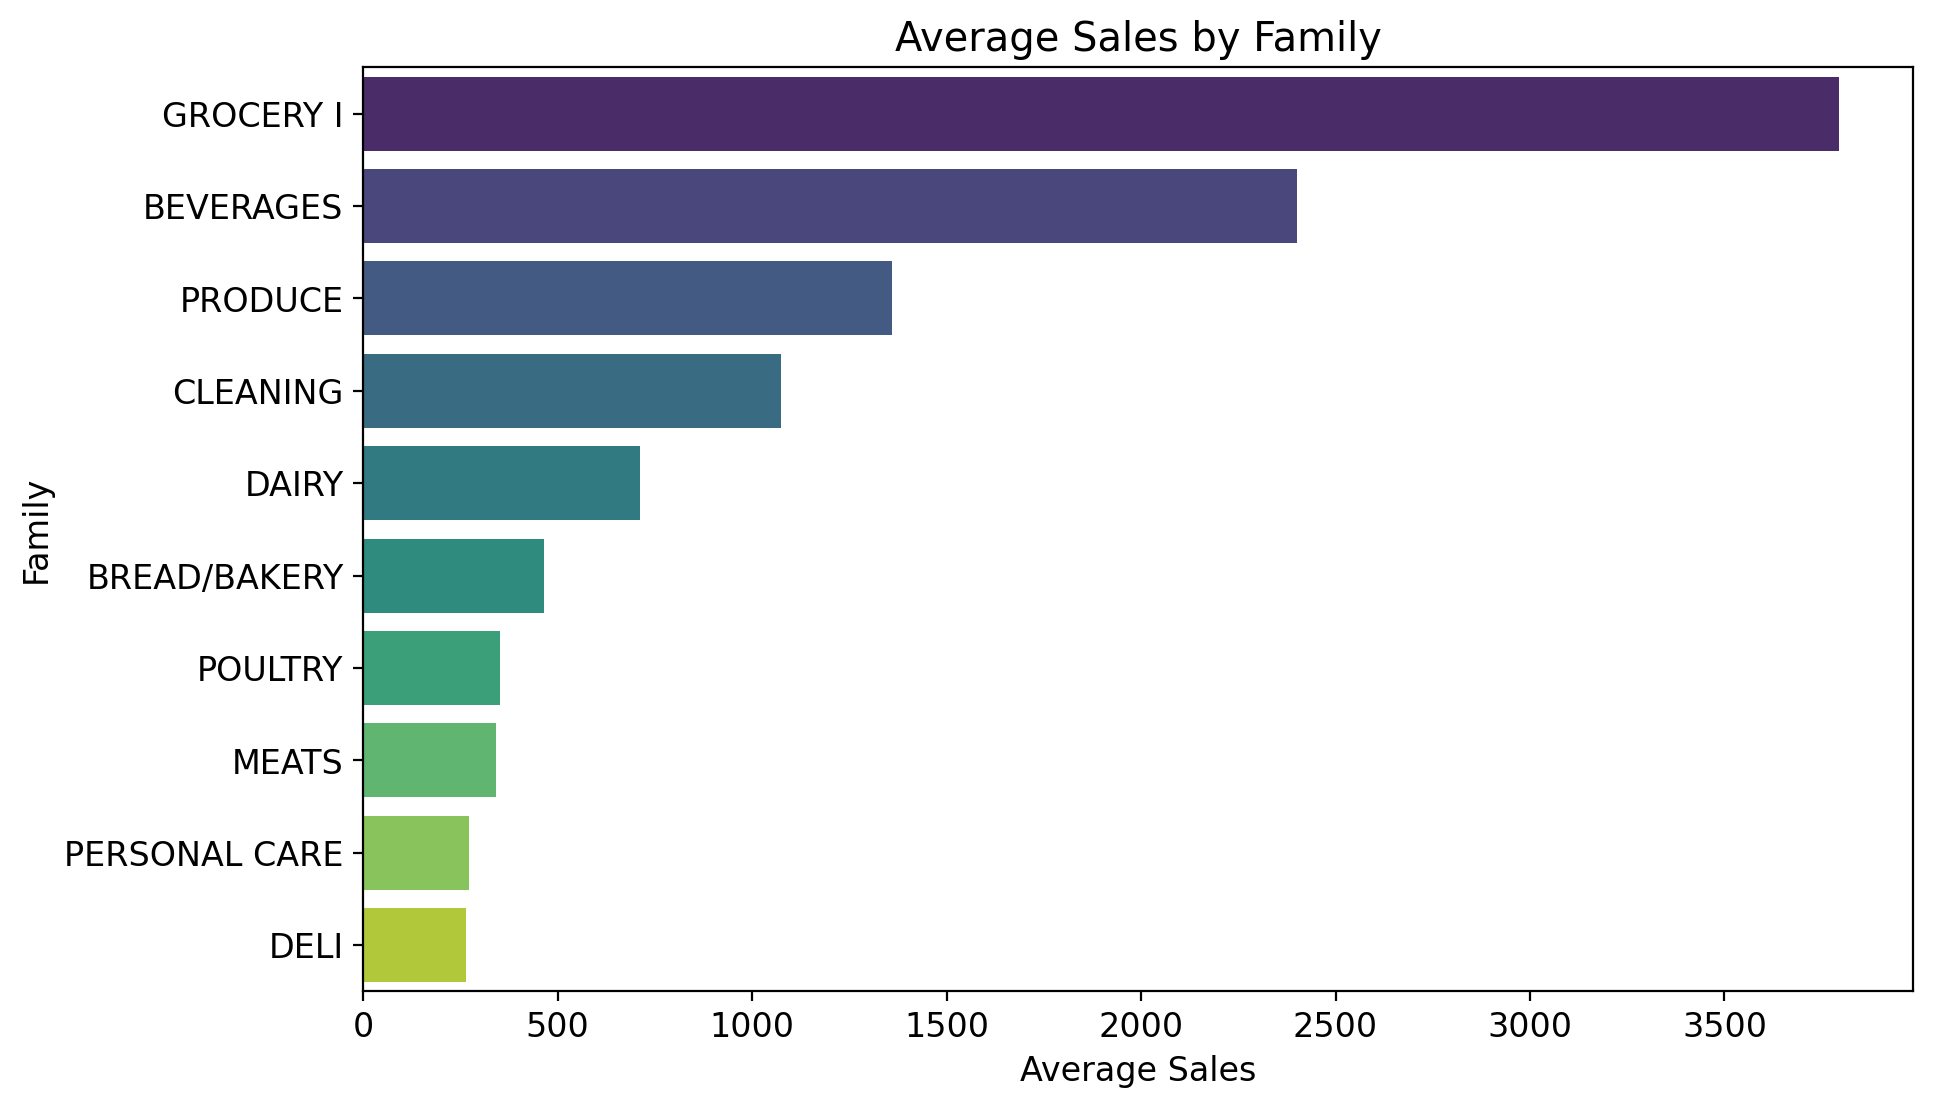

In [54]:
avr_sales_family = df.groupby('family')['sales'].mean().sort_values(ascending=False).head(10).reset_index()
sns.barplot(
    data=avr_sales_family,
    x='sales',
    y='family',
    hue='family',
    palette='viridis'
)
plt.xlabel('Average Sales')
plt.ylabel('Family')
plt.title('Average Sales by Family')

The first four product families have very high sales (GROCERY I, BEVERAGES, PRODUCE, CLEANING)

Text(0.5, 1.0, 'Correlation Matrix of Features')

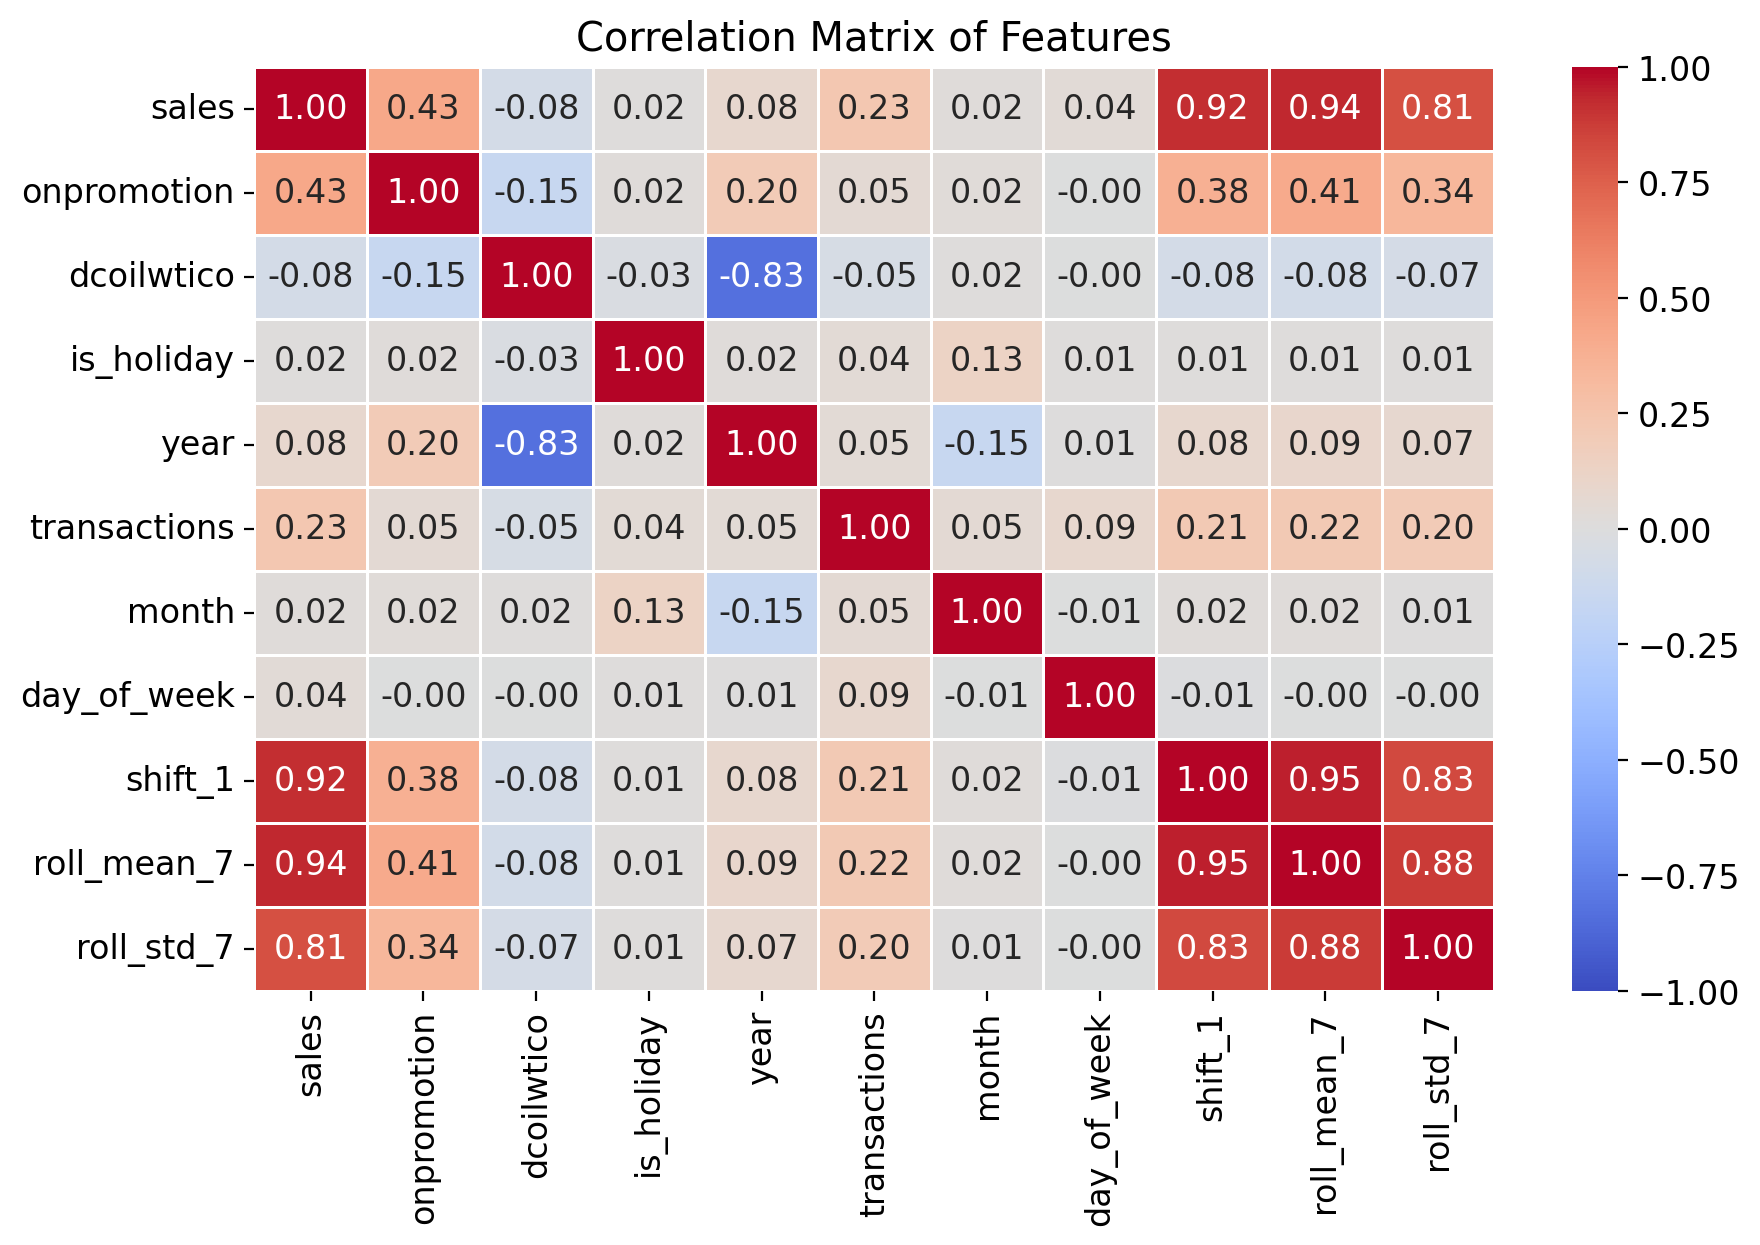

In [55]:
corr_cols = [
    'sales', 'onpromotion', 'dcoilwtico', 'is_holiday',
    'year', 'transactions', 'month', 'day_of_week', 
    'shift_1', 'roll_mean_7', 'roll_std_7' 
]

corr_matrix = df[corr_cols].corr()
sns.heatmap(
    data=corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Features')

We have built a correlation map between the features. From it we get that shift_1 and roll_mean_7 are strongly correlated with each other. Sales are also strongly correlated with shift_1 and roll_mean_7.